In [1]:
import numpy as np
from scipy import stats

import pymc3 as pm

import torch
import pyro
import pyro.infer as infer
import pyro.distributions as dist
from torch.distributions import constraints

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
colors = sns.color_palette().as_hex()
n_colors = len(colors)

seed = 100
np.random.seed(seed)

# 平均と標準偏差を推測する

単純なガウス分布のパラメータ推論

## 問題設定

- なんらかのガウス分布に従うn個の適当なサンプルデータがある
- データから、このガウス分布の平均と精度を推論する

## データ

In [3]:
#x = np.array([1.1, 1.9, 2.3, 1.8])
x = np.random.normal(2.0, 1.5, 100)

(array([0.01474352, 0.10320467, 0.1179482 , 0.19166582, 0.23589639,
        0.25063992, 0.19166582, 0.20640934, 0.10320467, 0.0589741 ]),
 array([-1.7307273 , -1.05246344, -0.37419957,  0.30406429,  0.98232816,
         1.66059202,  2.33885588,  3.01711975,  3.69538361,  4.37364748,
         5.05191134]),
 <BarContainer object of 10 artists>)

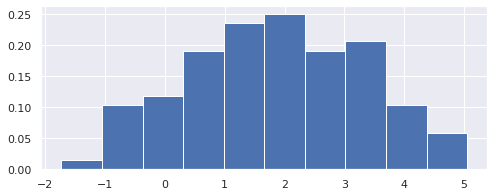

In [4]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1, 1)

ax.hist(x, density=True)

## 推論(PyMC)

### モデル定義

- 精度（標準偏差の逆数）の共役事前分布はガンマ分布だが、ガンマ分布を使うのはどうやら異論があるらしい
  - [Gelman(2006)](https://projecteuclid.org/download/pdf_1/euclid.ba/1340371048)
- そこで、十分な範囲を決めた一様分布を事前分布とする

In [5]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0.0, tau=0.0001)
    sigma = pm.Uniform('sigma', 0, 10)
    
    x_obs = pm.Normal('x_obs', mu=mu, sigma=sigma, observed=x)

### 推論

In [6]:
with model:
    trace = pm.sample(1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 4 seconds.
The acceptance probability does not match the target. It is 0.8787329896698488, but should be close to 0.8. Try to increase the number of tuning steps.


### 推論結果の確認

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

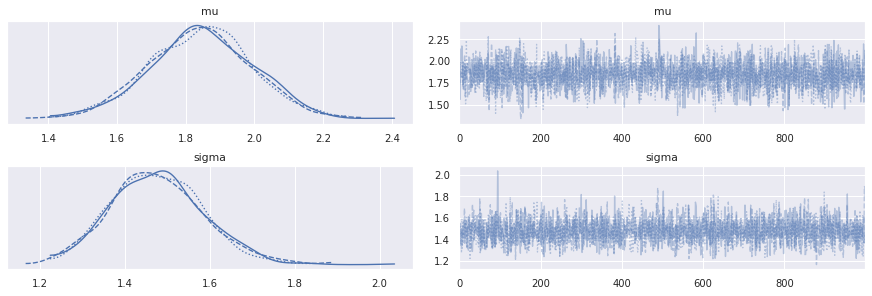

In [7]:
pm.traceplot(trace)

/usr/local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

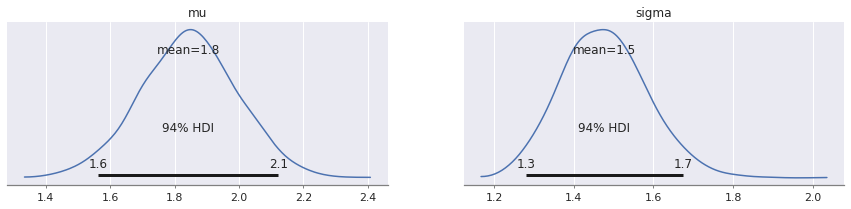

In [8]:
fig = plt.figure(figsize=(15, 3))
ax = fig.subplots(1, 2)

pm.plot_posterior(trace, ax=ax)

## 推論(Pyro)

### モデル定義

In [9]:
def model_gauss(params=None):
    mu0 = torch.tensor(0.0)
    sig0 = torch.tensor(np.sqrt(1/0.0001))
    mu = pyro.sample('mu', dist.Normal(mu0, sig0))
    
    low = torch.tensor(0.0)
    high = torch.tensor(10.0)
    sigma = pyro.sample('sigma', dist.Uniform(low, high))
    
    x = pyro.sample('x', dist.Normal(mu, sigma))
    return x

cond_model = pyro.condition(
    model_gauss, 
    data={'x':torch.tensor(x)}
)

### 推論

In [10]:
nuts_kernel = infer.NUTS(cond_model,  
                         adapt_step_size=True, 
                         jit_compile=True, 
                         ignore_jit_warnings=True)
mcmc = infer.MCMC(nuts_kernel, 
                  num_samples=1500,
                  warmup_steps=500,
                  num_chains=1)

In [11]:
mcmc.run()

Sample: 100%|██████████| 2000/2000 [00:09, 205.79it/s, step size=9.47e-01, acc. prob=0.898]


### 推論結果の確認

In [12]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      1.85      0.14      1.85      1.62      2.09   1419.74      1.00
     sigma      1.48      0.11      1.48      1.30      1.64   1621.11      1.00

Number of divergences: 0


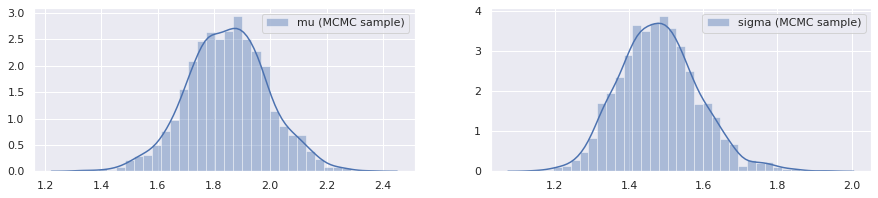

In [13]:
mu_sample = mcmc.get_samples()['mu']
sig_sample = mcmc.get_samples()['sigma']

fig = plt.figure(figsize=(15, 3))
ax = fig.subplots(1,2)
sns.distplot(mu_sample, ax=ax[0], label='mu (MCMC sample)')
sns.distplot(sig_sample, ax=ax[1], label='sigma (MCMC sample)')

ax[0].legend()
ax[1].legend()